## Q1. Downloading the data


We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [1]:
import pandas as pd
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [2]:
df.shape

(3066766, 19)

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the standard deviation of the trips duration in January?
   

In [3]:
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60


duration_std = df['duration'].std()
duration_std

42.594351241920904

## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?


<AxesSubplot:>

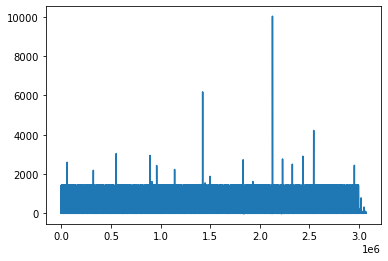

In [4]:
df['duration'].plot()

<AxesSubplot:>

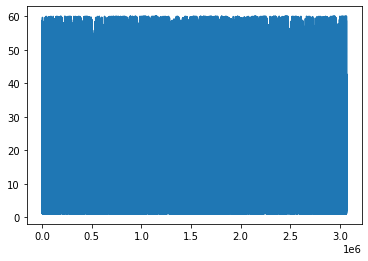

In [5]:
filterdf = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

filterdf['duration'].plot()


In [6]:
fraction= len(filterdf) / len(df)
fraction

0.9812202822125979

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will 
  label encode them)
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [7]:
filterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3009173 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [8]:
filterdf['PULocationID'] = filterdf['PULocationID'].apply(str)
filterdf['DOLocationID'] = filterdf['DOLocationID'].apply(str)

/tmp/ipykernel_14050/3494111886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterdf['PULocationID'] = filterdf['PULocationID'].apply(str)
/tmp/ipykernel_14050/3494111886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterdf['DOLocationID'] = filterdf['DOLocationID'].apply(str)


In [9]:
ids = filterdf[['PULocationID', 'DOLocationID']]
X = pd.get_dummies(ids, sparse=True)
X.shape

(3009173, 515)

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

y = filterdf['fare_amount'].values

In [11]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [12]:
y_pred = lr.predict(X)

In [13]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
rmse

9.876597916907475

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023). 

What's the RMSE on validation?

In [ ]:
dfv = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')
dfv.head()

In [ ]:
dfv.info()

In [ ]:
dfv['duration'] = (dfv['tpep_dropoff_datetime'] - dfv['tpep_pickup_datetime']).dt.total_seconds() / 60

filterdf2 = dfv[(dfv['duration'] >= 1) & (dfv['duration'] <= 60)]

In [ ]:
filterdf2['PULocationID'] = filterdf2['PULocationID'].apply(str)
filterdf2['DOLocationID'] = filterdf2['DOLocationID'].apply(str)

In [ ]:
ids2= filterdf2[['PULocationID', 'DOLocationID']]


X_val= pd.get_dummies(ids2, sparse=True)

X_val.shape

In [ ]:
y_val = filterdf2['duration'].values

In [ ]:
y_val_pred = lr.predict(X_val)

In [ ]:
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_val